
>#     **PRACTICA DE LA ASIGNATURA *NATURAL LANGUAGE PROCESSING - NLP -***
                                                                          Profesor  David Torrejón Moya
                                                                            Alumno  Francisco Javier Gonzálvez Chico

# Introducción 

La idea de la práctica es visitar aquellos temas que en cierta manera nos permitan ver más contenido del curso.

La práctica esta dividida en 4 o 5 subapartados, que ya tenéis en este mismo Notebook. Estos subapartados estan aquí para que rellenéis el código que hace falta para la realización de la práctica. Obviamente podéis usar tantas celdas como os hagan falta, es más es de agradecer si el código final esta algo "limpio". Usar funciones, algo de comentario, etc, etc...

Usaremos 2 datasets, uno para el primer ejercicio, y otro para el resto de ejercicios.

Ejercicios:


1.   Machine Learning vs Deep Learning (Acordaros que hay que implementar el pipeline visto en clase entero)

    1.1. Implementación de un modelo de Sentiment Analysis con algún algoritmo de Machine Learning Clásico.
    
    1.2. Implementación de un modelo de Sentiment Analysis con alguna arquitectura de Deep Learning.
    
    1.3. Breve Comparación de resultados. Confusion Matrix.
    
2. Hacer Analysis de los tweets del segundo dataset. Que temas aparecen? Como se representan estos temas? De que hablan unos y otros?

3. Escoged a uno de los dos presidentes, y escribid tweets como ellos, usando un Modelo Generativo.

En cada ejercicio, espero explicaciones y razonamientos del porque una arquitectura y no otra, por ejemplo en Deep Learning, porque usar Convolutionals en lugar de recurrentes, o en Machine Learning, Bayes en lugar de SVM. Hay que explicar el pipeline, sobretodo el preproceso de datos, con lo que habrá que hacer un pequeño estudio de que datos tenemos, y si hay cosas que se pueden ignorar, si hacéis stemming, o no, etc, etc...

Acordaros de que objetivo final no es que obtengáis una accuracy brutal, es que comprendais que pasa cuando usais un algoritmo u otro, y que problemas o beneficios nos dan.

![IMAGEN](https://i.pinimg.com/736x/19/63/8c/19638c0b33e2f7822d6806ce31d89d84--funny-cartoons-funny-jokes.jpg)

Mucha suerte y ánimo!



># **IMPORTACIONES Y DESCARGAS NECESARIAS**



In [72]:
# EJECUTAR SIEMPRE, LAS PRIMERAS, TODAS LAS CELDAS HASTA -EJERCICIO 1-

from google.colab import files, drive

import numpy as np
import pandas as pd
import io
import re
import spacy

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from keras.layers import Embedding, Input, Dense, Dropout, Concatenate, Conv2D, GlobalMaxPooling2D, Reshape, Average, average, Lambda, CuDNNLSTM, LSTM, Bidirectional
from keras.models import Model
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K

from gensim import corpora, models, similarities
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

from random import sample, shuffle, choice
from collections import Counter
from math import exp
from copy import copy

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# instalamos e importamos la librería de contraciones del inglés

!pip install contractions

import contractions

     |████████████████████████████████| 317kB 13.9MB/s 
     |████████████████████████████████| 245kB 57.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81702 sha256=8e9bd74899d28d8011bd7767fee3485ac9d5d727d0fffd3212e0c5a7d69fedfd
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [3]:
# instalamos e importamos la librería de stop words

!pip install stop_words

from stop_words import get_stop_words

stop_words = get_stop_words('en')
nlp = spacy.load('en_core_web_sm')

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32917 sha256=3c42fda0439324d36a8e56497f88477ccfde77b3f24363fb8e32fdcecece2ee4
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [4]:
# instalamos e importamos la librería de visualización pyLDAvis

!pip install pyLDAvis

import pyLDAvis.gensim

     |████████████████████████████████| 1.6MB 6.5MB/s 
     |████████████████████████████████| 552kB 46.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=6da64d6d3376dada13fcbbfae859ca77e10c119de3b7c4cb4b9905490d3db185
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=e84782d0149ff9a22f6f15ed9d7c65743c689dcffbae7171be18a29544740f98
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [5]:
# descargamos el fichero de Jerga de Dimitrios Effrosynidis

!wget https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt

# creamos un diccionario de jerga y su conversión correcta... lo usaremos en los preprocesamientos de los datasets
jerga = pd.read_csv("slang.txt", header = None, encoding = 'latin1', delimiter = "\t")
jerga.columns = ['Jerga', 'Texto']

jerga_dict = dict([(Jerga, Texto) for Jerga, Texto in zip(jerga.Jerga, jerga.Texto)])

--2020-02-21 19:27:40--  https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5181 (5.1K) [text/plain]
Saving to: ‘slang.txt’

slang.txt           100%[===================>]   5.06K  --.-KB/s    in 0s      

2020-02-21 19:27:40 (57.1 MB/s) - ‘slang.txt’ saved [5181/5181]



># **EJERCICIO 1**
###<pre>      ***Machine Learning vs Deep Learning***



>># **Dataset**



#####<pre>      Cargamos el Dataset "train_sentiment.csv"

In [0]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train_sentiment.csv to train_sentiment.csv
User uploaded file "train_sentiment.csv" with length 8664015 bytes


#####<pre>      Obtenemos una breve descripción, su estructura y le damos un primer vistazo

In [0]:
df1 = pd.read_csv(io.StringIO(uploaded['train_sentiment.csv'].decode('ISO-8859-1')))

print("\t\t NULOS\n", "\t\t-------\n", df1.isnull().any(), "\n\n", sep = '')

df1.describe()

		 NULOS
		-------
ItemID           False
Sentiment        False
SentimentText    False
dtype: bool




,ItemID,Sentiment
count,99989.000000,99989.000000
mean,50005.110042,0.564632
std,28865.894393,0.495808
min,1.000000,0.000000
25%,25009.000000,0.000000
50%,50006.000000,1.000000
75%,75003.000000,1.000000
max,100000.000000,1.000000


In [0]:
df1

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...
...,...,...,...
99984,99996,0,@Cupcake seems like a repeating problem hop...
99985,99997,1,@cupcake__ arrrr we both replied to each other...
99986,99998,0,@CuPcAkE_2120 ya i thought so
99987,99999,1,@Cupcake_Dollie Yes. Yes. I'm glad you had mor...


#####<pre>      Observamos que el Dataset tiene 99.689 filas y 3 columnas sin valores nulos
~~~
          > La primera columna -ItemID- es discreta [min = 1 ; max = 100.000], un identificador numérico único
            Suponemos que este dataset tuvo originalmente 100K filas y que en algún tratamiento anterior (probablemente una eliminación 
            de filas vacías) se descartaron 11 de sus registros
          > La segunda columna -Sentiment- es binaria [0 / 1] y se trata de la etiqueta indicadora del problema a resolver
          > La tercera columna -SentimentText- [string], contiene el texto a analizar en el problema
~~~

In [0]:
# eliminamos la columna ItemID ya que no nos va a aportar información útil

df1.drop(['ItemID'], axis = 1, inplace = True)

In [0]:
print("     COUNT\n", "    -------\n", df1['Sentiment'].value_counts(), "\n\n", sep = '')

for i in range(0, 10):
  print(df1['Sentiment'][i], "\t", df1['SentimentText'][i])

     COUNT
    -------
1    56457
0    43532
Name: Sentiment, dtype: int64


0 	                      is so sad for my APL friend.............
0 	                    I missed the New Moon trailer...
1 	               omg its already 7:30 :O
0 	           .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
0 	          i think mi bf is cheating on me!!!       T_T
0 	          or i just worry too much?        
1 	        Juuuuuuuuuuuuuuuuussssst Chillin!!
0 	        Sunny Again        Work Tomorrow  :-|       TV Tonight
1 	       handed in my uniform today . i miss you already
1 	       hmmmm.... i wonder how she my number @-)


#####<pre>      El Dataset está bastante balanceado con respecto a la etiqueta [1 - 56.46%  / 0 - 43.54%]
~~~
        A la vista de la etiqueta y del texto completo de los 10 primeros registros:
          > El valor 0 de la etiqueta apunta a un sentimiento negativo y el 1 a un sentimiento positivo
~~~

In [0]:
# transformamos la etiqueta para que sea más significativa

for fila in range(0, len(df1)):
  etiqueta = df1.loc[fila, 'Sentiment']

  etiqueta = 'POS' if etiqueta == 1 else 'NEG'

  df1.loc[fila, 'Sentiment'] = etiqueta

In [0]:
# función para extraer las palabras de la columna -SentimentText-

def extraer_vocab(df):
  vocab = list()

  for index, row in df.iterrows():
    for word in row['SentimentText'].strip().split(' '):
      if word not in vocab:
        vocab.append(word)

  print(f"Número de Palabras: {len(vocab)}")

  return vocab

In [0]:
vocab = extraer_vocab(df1)

Número de Palabras: 183645


#####<pre>      La columna -SentimentText- contiene 183.645 tokens diferentes, un vocabulario (creemos) demasiado amplio

>># **Pipeline**

#####<pre>        Nos enfrentamos a un problema de clasificación 'Supervised Learning'

![](https://dzone.com/storage/temp/3307020-ml-pipeline.png)



>># **Preprocesamiento**



#####<pre>      Bajamos a local el vocabulario obtenido para poder analizarlo con detalle (colab es limitado para esto)

In [0]:
v_df = pd.DataFrame({"words": vocab})
v_df.to_csv('/content/gdrive/My Drive/NLP/Practica Final/vocab.csv', sep = ';', decimal = '.', index = False)

#####<pre>      Tras observar el vocabulario, vemos que contiene muchas palabras 'complicadas' para nuestro trabajo:
~~~
          > Espacios sobrantes a izquierda y derecha de las palabras
          > Palabras mal escritas, mayúsculas incorrectas y letras muy repetidas para inferir énfasis (gunna, YouuuuU)
          > Números, Fechas y Horas
          > Caracteres Especiales
          > Emojis
          > Menciones de usuarios (@martin)
          > Hashtags (#lovesongs)
          > URLs
          > Jerga y Contracciones del lenguaje
          > Signos de puntuación
~~~

#####<pre>      Trataremos el vocabulario combinando técnicas de [**Dimitrios Effrosynidis**](https://github.com/Deffro/text-preprocessing-techniques) y [**Adriano Carmezim**](https://github.com/Carmezim/crypto-twitter-sentiment-analysis) 

In [0]:
# limpiamos en un orden lógico

for fila in range(0, len(df1)):
  texto = df1.loc[fila, 'SentimentText']

  # Ponemos todo en minúsculas
  texto = texto.lower()

  # Eliminamos el texto unicode ("\u002c", "x96", """)
  texto = re.sub(r'(\\u[0-9A-Fa-f]+)', '', texto)       
  texto = re.sub(r'[^\x00-\x7f]', '', texto)

  # Convertimos los Emojis Positivos
  texto = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:\s?D|:-D|x-?D|X-?D|@-\)|<3|:\*|;-?\)|;-?D|\(-?;)', 'EMO_POS', texto)
  
  # Convertimos los Emojis Negativos
  texto = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:,\(|:\'\(|:"\()|:-\||t_t', 'EMO_NEG', texto)

  # Eliminamos las URLs ya que entendemos que no aportarán información significativa al modelo
  texto = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', texto)
  texto = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', '', texto)

  # Eliminamos las menciones de usuarios porque creemos que los nombres o alias no tendrán significación en nuestro análisis
  texto = re.sub(r'@[\S]+', '', texto)
  texto = re.sub(r'@[^\s]+', '', texto)

  # Eliminamos los hashtags porque aunque quiza alguno pudiera apuntar un sentimiento, normalmente suelen ser palabras unidas #contraelcancer que no podrán aportar a nuestro análisis 
  texto = re.sub(r'#([^\s]+)', '', texto)
  texto = re.sub(r'#(\S+)', '', texto)

  # Eliminamos las siglas de los retweets 
  texto = re.sub(r'\brt\b', '', texto)

  # Eliminamos los signos de puntuación
  texto = re.sub(r'[\'"?!,.():;]', '', texto)

  # Eliminamos los caracteres especiales
  texto = re.sub(r'[^a-zA-z0-9\s]', '', texto)
  
  for t in texto.split(' '):    
    # Convertimos las repeticiones masivas de letras
    texto = texto.replace(t, re.sub(r'(.)\1+', r'\1\1', t))

    # Convertimos la jerga
    if t in jerga_dict:
      texto = texto.replace(t, jerga_dict[t])

  # Traducimos las contracciones
  texto = contractions.fix(texto)

  # Eliminamos los números
  texto = re.sub(r'[0123456789]', '', texto)

  # Eliminamos los espacios en blanco sobrantes
  texto = texto.strip()
  texto = re.sub(r'\s+', ' ', texto)

  df1.loc[fila, 'SentimentText'] = texto

#####<pre>      Veamos como ha quedado el vocabulario

In [0]:
vocab = extraer_vocab(df1)

Número de Palabras: 62981


#####<pre>      La columna -SentimentText- se ha reducido notablemente, de 183.645 a 62.981 tokens diferentes

#####<pre>      Lemmatizaremos, apoyándonos en la librería **spacy**, con objeto de normalizar el texto en lo posible

In [0]:
for fila in range(0, len(df1)):
  texto = nlp(df1.loc[fila, 'SentimentText'])
  texto = ' '.join([t.lemma_ if t.lemma_ != '-PRON-' else t.text for t in texto])

  df1.loc[fila, 'SentimentText'] = texto

#####<pre>      Decidimos no utilizar la eliminación de stop-words
~~~
          Consideramos que muchas de estas palabras pueden ser significativas para nuestro sentiment analysis
~~~

In [0]:
# Veamos como ha quedado nuestro dataset
print("\t\t NULOS\n", "\t\t-------\n", df1.isnull().any(), "\n\n", sep = '')

df1.describe()

		 NULOS
		-------
Sentiment        False
SentimentText     True
dtype: bool




,Sentiment,SentimentText
count,99989,99444
unique,2,95802
top,POS,thank
freq,56457,256


#####<pre>      Como nos temíamos, al eliminar tantos tokens suplerfluos se han vaciado totalmente algunos -SentimentText-

In [0]:
print(f"SentimentText está a 'null' en {df1['SentimentText'].isnull().sum()} registros\nProcedemos a eliminar estos registros que han quedado inservibles\n\n")

# Procedemos a eliminar los nulos
df1 = df1.drop(df1[(df1['SentimentText'].isnull())].index)

df1.describe()

SentimentText esta a 'null' en 545 registros
Procedemos a eliminar estos registros que han quedado inservibles




,Sentiment,SentimentText
count,99444,99444
unique,2,95802
top,POS,thank
freq,56124,256


---

In [0]:
# guardamos el trabajo para evitar reprocesos posteriores

df1.to_csv('/content/gdrive/My Drive/NLP/Practica Final/df1.csv', sep = ';', decimal = '.', index = False)

---

In [0]:
# desde aqui cargamos el dataset ya preprocesado (limpio)

df1 = pd.read_csv('/content/gdrive/My Drive/NLP/Practica Final/df1.csv', sep = ';', decimal = '.')

---

>># **Partición del Dataset**



#####<pre>      Reducimos el dataset a su quinta parte, ya que casi 100K filas serán demasiadas para entrenar los modelos

In [0]:
# aprovechamos la aleatoriedad de train_test_split para elegir la quinta parte de los registros del dataset

resto, df2 = train_test_split(df1, test_size = 0.2, shuffle = True, random_state = 0)

print(f"El dataset reducido a su quinta parte tiene {df2.shape[0]} filas")

El dataset reducido a su quinta parte tiene 19889 filas


#####<pre>      Realizamos las tres particiones:
~~~
          > un 70% del dataset servirá para el entrenamiento
          > un 10% del dataset servirá para la validación
          > un 20% del dataset servirá para el testeo
~~~

In [0]:
trainT, test = train_test_split(df2, test_size = 0.2, shuffle = True, random_state = 0)
train, validate = train_test_split(trainT, test_size = 0.1, shuffle = True, random_state = 0)

print(f"El conjunto Train    ha quedado con {train.shape[0]} filas y {train.shape[1]} columnas")
print(f"El conjunto Validate ha quedado con  {validate.shape[0]} filas y {validate.shape[1]} columnas")
print(f"El conjunto Test     ha quedado con  {test.shape[0]} filas y {test.shape[1]} columnas")

El conjunto Train    ha quedado con 14319 filas y 2 columnas
El conjunto Validate ha quedado con  1592 filas y 2 columnas
El conjunto Test     ha quedado con  3978 filas y 2 columnas


In [0]:
# preparamos los datos

# para los modelos de Machine Learning utilizaremos para entrenar la partición trainT (train + validate)
values_trnT = trainT.values

X_trnT = values_trnT[:, 1]
y_trnT = values_trnT[:, 0]

# para los modelos de Deep Learning utilizaremos en el entrenamiento train y validate por separado
values_trn = train.values
values_vld = validate.values
values_tst = test.values

X_trn = values_trn[:, 1]
y_trn = values_trn[:, 0]

X_vld = values_vld[:, 1]
y_vld = values_vld[:, 0]

X_tst = values_tst[:, 1]
y_tst = values_tst[:, 0]

>># **Modelo Machine Learning *Naive Bayes***

#####<pre>      El primer modelo predictor ML que implementaremos será un clasificador *Naive Bayes*:
~~~
          > Generaremos un Pipeline con un extractor de características y el modelo a entrenar
~~~

In [0]:
pipeline_nb = Pipeline([('extractor', CountVectorizer()),
                        ('modelo', MultinomialNB())])

# veamos que parámetros podemos configurar
pipeline_nb.get_params()

{'extractor': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 'extractor__analyzer': 'word',
 'extractor__binary': False,
 'extractor__decode_error': 'strict',
 'extractor__dtype': numpy.int64,
 'extractor__encoding': 'utf-8',
 'extractor__input': 'content',
 'extractor__lowercase': True,
 'extractor__max_df': 1.0,
 'extractor__max_features': None,
 'extractor__min_df': 1,
 'extractor__ngram_range': (1, 1),
 'extractor__preprocessor': None,
 'extractor__stop_words': None,
 'extractor__strip_accents': None,
 'extractor__token_pattern': '(?u)\\b\\w\\w+\\b',
 'extractor__tokenizer': None,
 'extractor__vocabulary': None,
 

#####<pre>      Para el ***extractor*** dejaremos la mayoría de valores a parametrizar por defecto, excepto:
~~~
          > max_df:      para asegurarnos que se ignoren palabras altamente repetidas (compensando así no haber filtrado las stop-words)
          > ngram_range: para probar con diferentes tamaños de n-grams
~~~
#####<pre>      Para el ***modelo*** dejaremos todos los valores a parametrizar por defecto, excepto:
~~~
          > alpha: para probar con diferentes regularizaciones
~~~

In [0]:
parameters_grid_nb = {'extractor__max_df': (0.5, 0.75, 1.0),
                      'extractor__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 3), (1, 4)),
                      'modelo__alpha': (1, 1e-1, 1e-2, 1e-3)}

# definimos nuestra grid de entreno
gs_nb = GridSearchCV(pipeline_nb, parameters_grid_nb, n_jobs = -1, verbose = 1)

# entrenamos la grid para obtener la mejor parametrización
# denotar que para los modelos de Machine Learning utilizaremos para el entrenamiento los conjuntos -train- y -validate- juntos
gs_nb.fit(X_trnT, y_trnT)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('extractor',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

In [0]:
# presentamos la mejor parametrización obtenida para el modelo NB
best_params_nb = gs_nb.best_estimator_.get_params()

print("La mejor parametrización obtenida por la Grid para el modelo NB es:")
for param_name in sorted(parameters_grid_nb.keys()):
    print("\t%s: %r" % (param_name, best_params_nb[param_name]))
print("\nMejor score: %0.3f" % gs_nb.best_score_)

La mejor parametrización obtenida por la Grid para el modelo NB es:
	extractor__max_df: 0.5
	extractor__ngram_range: (1, 2)
	modelo__alpha: 1

Mejor score: 0.741


#####<pre>     Nos parece que el mejor ***score*** obtenido en train por el modelo *Naive Bayes* es decente pero no demasiado bueno

#####<pre>     Parametrizaremos el ***pipeline*** con estos *mejores parámetros* obtenidos

In [0]:
# para sucesivas sesiones, evitamos entrenar de nuevo la grid imponiendo manualmente los mejores parámetros obtenidos
# pipeline_nb.set_params(**best_params_nb)

pipeline_nb = Pipeline([('extractor', CountVectorizer(max_df = 0.5, ngram_range = (1, 2))),
                        ('modelo', MultinomialNB(alpha = 1))])

pipeline_nb.fit(X_trnT, y_trnT)

Pipeline(memory=None,
         steps=[('extractor',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('modelo',
                 MultinomialNB(alpha=1, class_prior=None, fit_prior=True))],
         verbose=False)

#####<pre>     Evaluaremos el modelo contra el conjunto de datos de test

In [0]:
scoring_nb = pipeline_nb.score(X_tst, y_tst)
print("El scoring de accuracy obtenido para el modelo NB en test es %0.3f" % scoring_nb)

El scoring de accuracy obtenido para el modelo NB en test es 0.743


#####<pre>      Veamos su matriz de confusión

In [0]:
# función para pintar la matriz de confusión 
def plot_confusion_matrix(confmat, modelo, fsc):
    fig, ax = plt.subplots(figsize = (6, 6))
    ax.matshow(confmat, cmap = plt.cm.Purples, alpha = 0.5)

    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x = j, y = i, s = confmat[i, j], va = 'center', ha = 'center', size = 16)
    
    ax.xaxis.set_ticks_position('bottom')
    title = modelo + f'\nF1-SCORE: %0.3f' % fsc

    plt.title(title, size = 20)   
    plt.xlabel('predicción', size = 16)
    plt.ylabel('etiqueta', size = 16)

    target_names = ['NEG', "POS"]
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)

    plt.tight_layout()
    plt.show()

# función para obtener el F1-SCORE
def calculo_fsc(tp, fp, fn):
  sen = tp / (tp + fn)
  ppv = tp / (tp + fp)
  fsc = 2 * (sen * ppv / (sen + ppv))

  return fsc

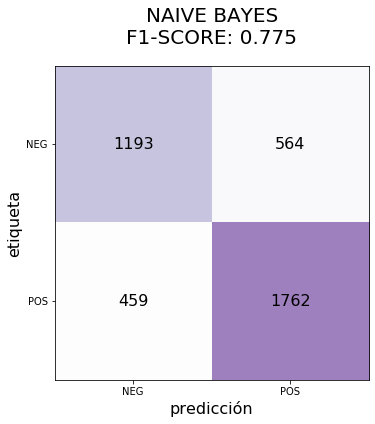


El conjunto de test tiene 3978 registros:
	 · 1193 + 564 = 1757 mensajes negativos
	 · 459 + 1762 = 2221 mensajes positivos

La matriz de confusión nos dice que de los 1757 mensajes con etiqueta NEG:
	 · 1193 se están prediciendo correctamente [predicción = NEG]
	 · 564 se están prediciendo como falsos positivos [predicción = POS]

Y que de los 2221 mensajes con etiqueta POS:
	 · 1762 se están prediciendo correctamente [predicción = POS]
	 · 459 se están prediciendo como falsos negativos [predicción = NEG]


In [0]:
y_pred_nb = pipeline_nb.predict(X_tst)
confmat_nb = confusion_matrix(y_tst, y_pred_nb)
tn, fp, fn, tp = confusion_matrix(y_tst, y_pred_nb).ravel()
fsc_nb = calculo_fsc(tp, fp, fn)
plot_confusion_matrix(confmat_nb, 'NAIVE BAYES', fsc_nb)

print(f"\nEl conjunto de test tiene {tn + fp + fn + tp} registros:")
print(f"\t · {tn} + {fp} = {tn + fp} mensajes negativos\n\t · {fn} + {tp} = {tp + fn} mensajes positivos")
print(f"\nLa matriz de confusión nos dice que de los {tn + fp} mensajes con etiqueta NEG:")
print(f"\t · {tn} se están prediciendo correctamente [predicción = NEG]")
print(f"\t · {fp} se están prediciendo como falsos positivos [predicción = POS]")
print(f"\nY que de los {tp + fn} mensajes con etiqueta POS:")
print(f"\t · {tp} se están prediciendo correctamente [predicción = POS]")
print(f"\t · {fn} se están prediciendo como falsos negativos [predicción = NEG]")

>># **Modelo Machine Learning *Support Vector Machine (SVM)***

#####<pre>      El segundo modelo predictor ML que implementaremos será un clasificador *SVM*:
~~~
          > Generaremos un Pipeline con un extractor de características y el modelo a entrenar (las SVM ya integran un parámetro regularizador)
~~~

In [0]:
pipeline_svm = Pipeline([('extractor', CountVectorizer()),
                         ('modelo', SVC(class_weight = 'balanced', probability = True))])

# veamos que parámetros podemos configurar
pipeline_svm.get_params()

{'extractor': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 'extractor__analyzer': 'word',
 'extractor__binary': False,
 'extractor__decode_error': 'strict',
 'extractor__dtype': numpy.int64,
 'extractor__encoding': 'utf-8',
 'extractor__input': 'content',
 'extractor__lowercase': True,
 'extractor__max_df': 1.0,
 'extractor__max_features': None,
 'extractor__min_df': 1,
 'extractor__ngram_range': (1, 1),
 'extractor__preprocessor': None,
 'extractor__stop_words': None,
 'extractor__strip_accents': None,
 'extractor__token_pattern': '(?u)\\b\\w\\w+\\b',
 'extractor__tokenizer': None,
 'extractor__vocabulary': None,
 

#####<pre>      Para el ***extractor*** dejaremos la mayoría de valores a parametrizar por defecto, excepto:
~~~
          > analyzer:    probaremos con palabras y caracteres
          > max_df:      para asegurarnos que se ignoren palabras altamente repetidas (compensando así no haber filtrado las stop-words)
          > ngram_range: para probar con diferentes tamaños de n-grams
~~~
#####<pre>      Para el ***modelo*** dejaremos la mayoría de valores a parametrizar por defecto, excepto:
~~~
          > kernel: para probar lineal y exponencial
          > C:      para probar diferentes grados de regularización
~~~

In [0]:
# esta es la grid de parámetros con la que deseabamos entrenar la SVM
# no entendemos porqué (probablemente por falta de recursos) no nos ha sido posible finalizar ningún entrenamiento con estos juegos de valores y lo hemos intentado repetidas veces
# de hecho (como se puede observar en la siguiente celda) para poder ver una finalización del entrenamiento hemos tenido que reducirlos al mínimo e incluso disminuir el K-fold a 3 

parameters_grid_svm = {'extractor__analyzer': ('word', 'char'),
                       'extractor__max_df': (0.5, 0.75, 1.0),
                       'extractor__ngram_range': ((1, 3), (2, 3), (1, 4)),
                       'modelo__kernel': ('rbf', 'linear'),
                       'modelo__C': (1, 1e-1)}

In [0]:
# grid reducida a su mínima expresión 
parameters_grid_svm = {'modelo__C': (1, 1e-1)}

# definimos nuestra grid de entreno con disminución del K-fold a 3
gs_svm = GridSearchCV(pipeline_svm, parameters_grid_svm, n_jobs = -1, verbose = 1, cv = 3)

# entrenamos la grid para obtener la mejor parametrización
# denotar que para los modelos de Machine Learning utilizaremos para el entrenamiento los conjuntos -train- y -validate- juntos.
gs_svm.fit(X_trnT, y_trnT)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  7.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('extractor',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                       

In [0]:
# presentamos la mejor parametrización obtenida para el modelo SVM
best_params_svm = gs_svm.best_estimator_.get_params()

print("La mejor parametrización obtenida por la Grid para el modelo SVM es:")
for param_name in sorted(parameters_grid_svm.keys()):
    print("\t%s: %r" % (param_name, best_params_svm[param_name]))
print("\nMejor score: %0.3f" % gs_svm.best_score_)

La mejor parametrización obtenida por la Grid para el modelo SVM es:
	modelo__C: 1

Mejor score: 0.734


#####<pre>     Parece que el mejor ***score*** obtenido en train por el modelo *SVM* [0.734] es peor que el del *Naive Bayes*
~~~
          Debemos indicar (tal y como se puede ver en las celdas de entrenamiento de este modelo SVM) que nos ha sido imposible entrenarlo
          con la parametrización deseada
          Para poder ver finalizar el entrenamientos tuvimos que reducir la parametrización al mínimo e incluso disminuir el K-fold a 3
          Y el resultado fue la parametrización por defecto del Pipeline
          Muy probablemente, conociendo la potencia de las Support Vector Machines, de haber podido ejecutar un mejor entrenamiento, como
          pretendiamos, con varios parámetros y diferentes valores, su score final hubiera mejorado bastante al del modelo Naive Bayes
~~~

#####<pre>     Parametrizaremos el ***pipeline*** con estos *mejores parámetros* obtenidos

In [0]:
# para sucesivas sesiones, evitamos entrenar de nuevo la grid imponiendo manualmente los mejores parámetros obtenidos
# pipeline_svm.set_params(**best_params_svm)

pipeline_svm = Pipeline([('extractor', CountVectorizer()),
                         ('modelo', SVC(C = 1, class_weight = 'balanced', probability = True))])

pipeline_svm.fit(X_trnT, y_trnT)

Pipeline(memory=None,
         steps=[('extractor',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('modelo',
                 SVC(C=1, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shr

#####<pre>     Evaluaremos el modelo contra el conjunto de datos de test

In [0]:
scoring_svm = pipeline_svm.score(X_tst, y_tst)
print("El scoring de accuracy obtenido para el modelo SVM en test es %0.3f" % scoring_svm)

El scoring de accuracy obtenido para el modelo SVM en test es 0.761


#####<pre>     Sorprendentemente, la *SVM* con su parametrización por defecto, supera el score del *Naive Bayes*

#####<pre>      Veamos su matriz de confusión

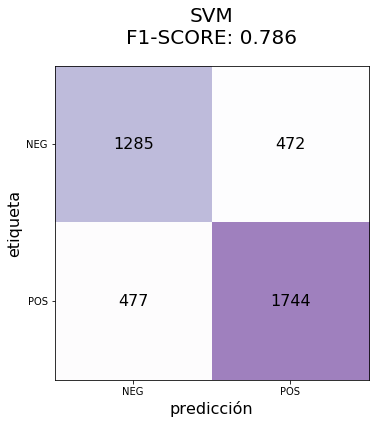


El conjunto de test tiene 3978 registros:
	 · 1285 + 472 = 1757 mensajes negativos
	 · 477 + 1744 = 2221 mensajes positivos

La matriz de confusión nos dice que de los 1757 mensajes con etiqueta NEG:
	 · 1285 se están prediciendo correctamente [predicción = NEG]
	 · 472 se están prediciendo como falsos positivos [predicción = POS]

Y que de los 2221 mensajes con etiqueta POS:
	 · 1744 se están prediciendo correctamente [predicción = POS]
	 · 477 se están prediciendo como falsos negativos [predicción = NEG]


In [0]:
y_pred_svm = pipeline_svm.predict(X_tst)
confmat_svm = confusion_matrix(y_tst, y_pred_svm)
tn, fp, fn, tp = confusion_matrix(y_tst, y_pred_svm).ravel()
fsc_svm = calculo_fsc(tp, fp, fn)
plot_confusion_matrix(confmat_svm, 'SVM', fsc_svm)

print(f"\nEl conjunto de test tiene {tn + fp + fn + tp} registros:")
print(f"\t · {tn} + {fp} = {tn + fp} mensajes negativos\n\t · {fn} + {tp} = {tp + fn} mensajes positivos")
print(f"\nLa matriz de confusión nos dice que de los {tn + fp} mensajes con etiqueta NEG:")
print(f"\t · {tn} se están prediciendo correctamente [predicción = NEG]")
print(f"\t · {fp} se están prediciendo como falsos positivos [predicción = POS]")
print(f"\nY que de los {tp + fn} mensajes con etiqueta POS:")
print(f"\t · {tp} se están prediciendo correctamente [predicción = POS]")
print(f"\t · {fn} se están prediciendo como falsos negativos [predicción = NEG]")

>># **Modelo Deep Learning *Convolutional Neural Network (CNN)***

#####<pre>      El primer modelo predictor DL que implementaremos será una Red Convolucional

#####<pre>      Pero lo primero será preparar los datos de entrenamiento para el Deep Learning
~~~
          Este preprocesamiento en el que tokenizaremos los registros para extraer el vocabulario y marcar el umbral de descarte de
          registros outliers, lo realizaremos únicamente sobre los 14.319 registros del conjunto de entrenamiento
          Los conjuntos de validación y testeo serán sometidos después a la preparación basada en las referencias tomadas de train,
          para así medir objetivamente la capacidad de predicción de los modelos
~~~

In [0]:
# función para el tokenizado de las particiones de datos
def tokenizado(textos, clases):
  tokens = []
  docs_tokenizados = []

  for x, y in zip(textos, clases):
      token = [t.text for t in nlp(x)]
      tokens += token
      docs_tokenizados.append((token, y))
  
  return tokens, docs_tokenizados

In [0]:
# tokenizamos los datos del conjunto de train

tokens, docs_trn = tokenizado(X_trn, y_trn)

print(f"Tenemos {len(docs_trn)} registros y {len(tokens)} tokens/palabras en el conjunto de train")

Tenemos 14319 registros y 182855 tokens/palabras en el conjunto de train


In [0]:
# vocabulario de los datos de train

vocab_counter = Counter(tokens)
vocab = list(vocab_counter.keys())

print(f"Tenemos {len(vocab)} tokens/palabras diferentes en el conjunto de train")

Tenemos 15416 tokens/palabras diferentes en el conjunto de train


In [0]:
# tratamiento de outliers

# longitud máxima de los documentos
maxlen = max([len(x) for x, _ in docs_trn])

# longitud de cada documento
lens = [len(x) for x, _ in docs_trn]

# mediana de la lista de longitudes de documento
mediana = np.median(np.array(lens))
media = np.mean(np.array(lens))

# calculamos el límite outlier como el doble de la mediana
maxlen = int(mediana)*2

print(f"Mediana de las longitudes de documento en train: {int(mediana)} palabras")
print(f"Máxima Longitud, límite outlier: {maxlen} palabras")

# filtramos los documentos tokenizados para desechar los que tienen mas de 24 palabras
docs_trn_ok = [(x, y) for x, y in docs_trn if len(x) <= maxlen]

print(f"\nEl conjunto de train sin outliers queda con {len(docs_trn_ok)} documentos")
print(f"Se desechan {len(docs_trn) - len(docs_trn_ok)} documentos demasiado largos.")

Mediana de las longitudes de documento en train: 12 palabras
Máxima Longitud, límite outlier: 24 palabras

El conjunto de train sin outliers queda con 13402 documentos
Se desechan 917 documentos demasiado largos.


In [0]:
# indexamos el vocabulario y las etiquetas
w2id = {k:i for i, k in enumerate(vocab)}

labels = ['NEG', 'POS']
l2id = {label:i for i, label in enumerate(labels)}

# añadimos el PAD <UNK> al vocabulario indexado para poder clasificar palabras desconocidas o que no aparezcan un mínimo de veces en el corpus
w2id['<UNK>'] = len(w2id)

In [0]:
# función para realizar el encoder de los conjuntos de datos particionados
def encoder_corpus(data, maxlen, vocab_counter, w2id, min_apar):
  corpus = list()

  for x, y in data:
    texto = np.zeros((maxlen))
    label = np.zeros(2)

    if y == 'NEG':
      label[0] = 1
    else:
      label[1] = 1

    for i, t in enumerate(x):
        texto[i] = w2id[t] if t in vocab_counter and vocab_counter[t] >= min_apar else w2id['<UNK>']

    corpus.append((texto, label))
  
  x, y = zip(*corpus)
  textos = np.array(list(x))
  labels = np.array(list(y))

  return textos, labels

In [0]:
# establecemos que para considerar un token/palabra debe haber aparecido en el vocabulario total al menos 5 veces
MIN_APARICIONES = 5

# codificamos el conjunto de datos de entrenamiento
textos_trn, labels_trn = encoder_corpus(docs_trn_ok, maxlen, vocab_counter, w2id, MIN_APARICIONES)

print(f"El formato de las features de train ha quedado con {textos_trn.shape[1]} columnas")

El formato de las features de train ha quedado con 24 columnas


In [0]:
# realizamos el mismo tokenizado, tratamiento de outliers y encoder para los datos de los conjuntos de validación y test, tomando como referencia el vocabulario de train

_, docs_vld = tokenizado(X_vld, y_vld)
docs_vld_ok = [(x, y) for x, y in docs_vld if len(x) <= maxlen]
textos_vld, labels_vld  = encoder_corpus(docs_vld_ok, maxlen, vocab_counter, w2id, MIN_APARICIONES)

_, docs_tst = tokenizado(X_tst, y_tst)
docs_tst_ok = [(x, y) for x, y in docs_tst if len(x) <= maxlen]
textos_tst, labels_tst  = encoder_corpus(docs_tst_ok, maxlen, vocab_counter, w2id, MIN_APARICIONES)

#####<pre>      Montamos nuestra arquitectura CNN

In [0]:
# capa de entrada con 24 neuronas
input_layer = Input(shape = (maxlen,))

# capa embedding con 100 vectores clasificadores de salida
embedding = Embedding(output_dim = 100, input_dim = len(w2id), input_length = maxlen)(input_layer)

# capa de reestructuración
reshape = Reshape((maxlen, 100, 1))(embedding)

# tres capas convolucionales 2D (activadas por 'relu'), con MaxPooling (para reducir overfitting) que filtrarán en paralelo con diferentes kernel
conv_1 = Conv2D(filters = 50, kernel_size = (1, 100), activation = 'relu', padding = 'valid')(reshape)
mp_1 = GlobalMaxPooling2D()(conv_1)
conv_2 = Conv2D(filters = 50, kernel_size = (2, 100), activation = 'relu', padding = 'valid')(reshape)
mp_2 = GlobalMaxPooling2D()(conv_2)
conv_5 = Conv2D(filters = 50, kernel_size = (5, 100), activation = 'relu', padding = 'valid')(reshape)
mp_5 = GlobalMaxPooling2D()(conv_5)

# concatenamos las salidas de las capas convolucionales para que entren en la etapa final
concatenacion = Concatenate()([mp_1, mp_2, mp_5])

# 2 capas densas (activadas por 'relu') con dropout (para reducir overfitting)
dense_1 = Dense(100, activation = 'relu')(concatenacion)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(100, activation = 'relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)

# capa densa de salida (softmax) con las clases a predecir
out_layer = Dense(len(l2id), activation = 'softmax')(drop_2)

# definimos el modelo CNN
model_cnn = Model(inputs = input_layer, outputs = out_layer)

# compilamos 
model_cnn.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

model_cnn.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 24, 100)      1541700     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 24, 100, 1)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 1, 50)    5050        resha

In [0]:
# entrenamos nuestro modelo CNN 5 épocas con batch_size 256, evaluándolo contra los datos de validación 
model_cnn.fit(textos_trn, labels_trn, epochs = 5, batch_size = 256,
              validation_data = (textos_vld, labels_vld))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 13402 samples, validate on 1473 samples
Epoch 1/5





13402/13402 [==============================] - 7s 504us/step - loss: 0.6348 - acc: 0.6386 - val_loss: 0.5348 - val_acc: 0.7373
Epoch 2/5
13402/13402 [==============================] - 6s 425us/step - loss: 0.5214 - acc: 0.7481 - val_loss: 0.5037 - val_acc: 0.7631
Epoch 3/5
13402/13402 [==============================] - 6s 432us/step - loss: 0.4719 - acc: 0.7814 - val_loss: 0.5008 - val_acc: 0.7542
Epoch 4/5
13402/13402 [==============================] - 6s 424us/step - loss: 0.4390 - acc: 0.8008 - val_loss: 0.4981 - val_acc: 0.7631
Epoch 5/5
13402/13402 [==============================] - 6s 422us/step - loss: 0.4097 - acc: 0.8191 - val_loss: 0.5332 - val_acc: 0.7583


In [0]:
scoring_cnn = model_cnn.evaluate(textos_tst, labels_tst)

print("El scoring de accuracy obtenido para el modelo CNN en test es %0.3f" % scoring_cnn[1])

3741/3741 [==============================] - 0s 105us/step
El scoring de accuracy obtenido para el modelo CNN en test es 0.748


#####<pre>     La *CNN* obtiene un scoring intermedio entre los modelos de ML *Naive Bayes* y *SVM*
~~~
          A la vista de la sucesion de las épocas de entrenamiento, la CNN tiende al overfitting
          Hemos decidido no entrenar mas épocas, ni bajar el batch_size por este motivo... parece que memoriza los datos
          de train sin mejorar nada contra el conjunto de validación
~~~

#####<pre>     Veamos su matriz de confusión

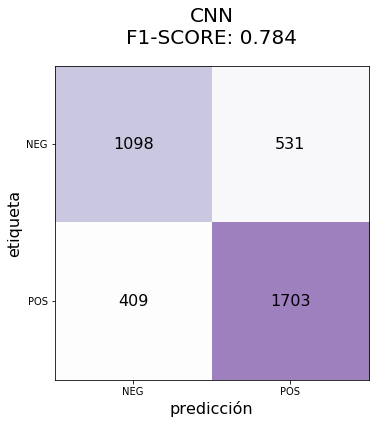


El conjunto de test tiene 3741 registros:
	 · 1098 + 531 = 1629 mensajes negativos
	 · 409 + 1703 = 2112 mensajes positivos

La matriz de confusión nos dice que de los 1629 mensajes con etiqueta NEG:
	 · 1098 se están prediciendo correctamente [predicción = NEG]
	 · 531 se están prediciendo como falsos positivos [predicción = POS]

Y que de los 2112 mensajes con etiqueta POS:
	 · 1703 se están prediciendo correctamente [predicción = POS]
	 · 409 se están prediciendo como falsos negativos [predicción = NEG]


In [0]:
predictions_cnn = model_cnn.predict(textos_tst)
confmat_cnn = confusion_matrix(labels_tst.argmax(axis = 1), predictions_cnn.argmax(axis = 1))
tn, fp, fn, tp = confusion_matrix(labels_tst.argmax(axis = 1), predictions_cnn.argmax(axis = 1)).ravel()
fsc_cnn = calculo_fsc(tp, fp, fn)
plot_confusion_matrix(confmat_cnn, 'CNN', fsc_cnn)

print(f"\nEl conjunto de test tiene {tn + fp + fn + tp} registros:")
print(f"\t · {tn} + {fp} = {tn + fp} mensajes negativos\n\t · {fn} + {tp} = {tp + fn} mensajes positivos")
print(f"\nLa matriz de confusión nos dice que de los {tn + fp} mensajes con etiqueta NEG:")
print(f"\t · {tn} se están prediciendo correctamente [predicción = NEG]")
print(f"\t · {fp} se están prediciendo como falsos positivos [predicción = POS]")
print(f"\nY que de los {tp + fn} mensajes con etiqueta POS:")
print(f"\t · {tp} se están prediciendo correctamente [predicción = POS]")
print(f"\t · {fn} se están prediciendo como falsos negativos [predicción = NEG]")

>># **Modelo Deep Learning *Arquitectura DAN***

#####<pre>      El segundo modelo predictor DL que implementaremos será una Arquitectura DAN

In [0]:
# funciones auxiliares

def mask_aware_mean(x):
    mask = K.not_equal(K.sum(K.abs(x), axis = 2, keepdims = True), 0)
    n = K.sum(K.cast(mask, 'float32'), axis = 1, keepdims = False)
    x_mean = K.sum(x, axis=1, keepdims = False) / n
    return x_mean

def mask_aware_mean_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3
    return (shape[0], shape[2])

In [0]:
# capa de entrada con 24 neuronas
input_layer_2 = Input(shape = (maxlen,))

# capa embedding con 100 vectores clasificadores de salida
embedding_2 = Embedding(output_dim = 100, input_dim = len(w2id), input_length = maxlen)(input_layer_2)

# capa de promediado de features embeddings
promediado = Lambda(mask_aware_mean, mask_aware_mean_output_shape, name='embedding_average')(embedding_2)

# 2 capas densas (activadas por 'relu') con dropout (para reducir overfitting)
dense_1_2 = Dense(100, activation = 'relu')(promediado)
drop_1_2 = Dropout(0.75)(dense_1_2)
dense_2_2 = Dense(100, activation = 'relu')(drop_1_2)
drop_2_2 = Dropout(0.75)(dense_2_2)

# capa densa de salida (softmax) con las clases a predecir
out_layer_2 = Dense(len(l2id), activation = 'softmax')(drop_2_2)

# definimos el modelo CNN
model_dan = Model(inputs = input_layer_2, outputs = out_layer_2)

# compilamos 
model_dan.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

model_dan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 24)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 24, 100)           1541700   
_________________________________________________________________
embedding_average (Lambda)   (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0   

In [0]:
# entrenamos nuestro modelo DAN 5 épocas con batch_size 256, evaluándolo contra los datos de validación 
model_dan.fit(textos_trn, labels_trn, epochs = 5, batch_size = 256,
              validation_data = (textos_vld, labels_vld))

Train on 13402 samples, validate on 1473 samples
Epoch 1/5
13402/13402 [==============================] - 2s 147us/step - loss: 0.6818 - acc: 0.5622 - val_loss: 0.6690 - val_acc: 0.5743
Epoch 2/5
13402/13402 [==============================] - 2s 113us/step - loss: 0.6546 - acc: 0.6088 - val_loss: 0.6000 - val_acc: 0.6864
Epoch 3/5
13402/13402 [==============================] - 2s 116us/step - loss: 0.5850 - acc: 0.7030 - val_loss: 0.5474 - val_acc: 0.7400
Epoch 4/5
13402/13402 [==============================] - 2s 116us/step - loss: 0.5352 - acc: 0.7460 - val_loss: 0.5186 - val_acc: 0.7542
Epoch 5/5
13402/13402 [==============================] - 2s 116us/step - loss: 0.5039 - acc: 0.7686 - val_loss: 0.5142 - val_acc: 0.7542


In [0]:
scoring_dan = model_dan.evaluate(textos_tst, labels_tst)

print("El scoring de accuracy obtenido para el modelo DAN en test es %0.3f" % scoring_dan[1])

3741/3741 [==============================] - 0s 39us/step
El scoring de accuracy obtenido para el modelo DAN en test es 0.758


#####<pre>     La *DAN* obtiene el mejor scoring de todos los modelos vistos
~~~
          Esta arquitectura parece que también tiende al overfitting
          Al igual que con la CNN, hemos decidido no entrenar mas épocas, ni bajar el batch_size por este motivo
~~~

#####<pre>     Veamos su matriz de confusión

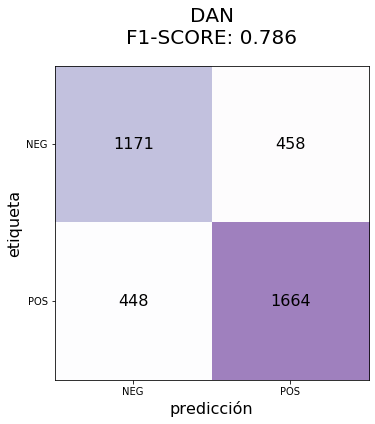


El conjunto de test tiene 3741 registros:
	 · 1171 + 458 = 1629 mensajes negativos
	 · 448 + 1664 = 2112 mensajes positivos

La matriz de confusión nos dice que de los 1629 mensajes con etiqueta NEG:
	 · 1171 se están prediciendo correctamente [predicción = NEG]
	 · 458 se están prediciendo como falsos positivos [predicción = POS]

Y que de los 2112 mensajes con etiqueta POS:
	 · 1664 se están prediciendo correctamente [predicción = POS]
	 · 448 se están prediciendo como falsos negativos [predicción = NEG]


In [0]:
predictions_dan = model_dan.predict(textos_tst)
confmat_dan = confusion_matrix(labels_tst.argmax(axis = 1), predictions_dan.argmax(axis = 1))
tn, fp, fn, tp = confusion_matrix(labels_tst.argmax(axis = 1), predictions_dan.argmax(axis = 1)).ravel()
fsc_dan = calculo_fsc(tp, fp, fn)
plot_confusion_matrix(confmat_dan, 'DAN', fsc_dan)

print(f"\nEl conjunto de test tiene {tn + fp + fn + tp} registros:")
print(f"\t · {tn} + {fp} = {tn + fp} mensajes negativos\n\t · {fn} + {tp} = {tp + fn} mensajes positivos")
print(f"\nLa matriz de confusión nos dice que de los {tn + fp} mensajes con etiqueta NEG:")
print(f"\t · {tn} se están prediciendo correctamente [predicción = NEG]")
print(f"\t · {fp} se están prediciendo como falsos positivos [predicción = POS]")
print(f"\nY que de los {tp + fn} mensajes con etiqueta POS:")
print(f"\t · {tp} se están prediciendo correctamente [predicción = POS]")
print(f"\t · {fn} se están prediciendo como falsos negativos [predicción = NEG]")

>># **Todos los Modelos Prediciendo**

#####<pre>     Vamos a elegir 20 registros POS y 20 NEG, al azar, de los datos que desechamos para reducir el dataset

In [0]:
values_resto = resto.values
n_regs = 20

# elegimos 20 registros 'POS' y 20 'NEG' (tenemos en cuenta que no superen el maxlen de palabras para que los modelos de depp learning puedan predecir)
ej_POS = sample([(label, text) for label, text in values_resto if (label == 'POS' and len(text.split(' ')) <= maxlen)], n_regs)
ej_NEG = sample([(label, text) for label, text in values_resto if (label == 'NEG' and len(text.split(' ')) <= maxlen)], n_regs)

# preparacion para ML
corpus = ej_POS + ej_NEG
y, x = zip(*corpus)
textos_ml = np.array(list(x), dtype = object)
labels_ml = np.array(list(y), dtype = object)

# preparacion para DL
_, textos_tk = tokenizado(textos_ml, labels_ml)
textos_tk_ok = [(x, y) for x, y in textos_tk if len(x) <= maxlen]
textos_dl, _  = encoder_corpus(textos_tk_ok, maxlen, vocab_counter, w2id, MIN_APARICIONES)

for i in range(0, len(ej_POS)):
  print(ej_POS[i], "\n\t\t\t\t\t\t\t\t\t\t\t", ej_NEG[i]) 

('POS', 'follow me so i can dm you my new like when i call and i get a personal greeting') 
											 ('NEG', 'i can haz umbrella but i be already damp from go to asda I will come and sing at you another time')
('POS', 'goodnight I be from vancouver bc') 
											 ('NEG', 'no more food for you')
('POS', 'people talk abt other people kidsall child be precious') 
											 ('NEG', 'aww poor grant look cool tho')
('POS', 'we end up do very little shopping and more wandering than anything my hubby wear me outi can not keep up with him') 
											 ('NEG', 'but its less than hour from you')
('POS', 'I be glad to hear your theory be at least well found so then who would apldeap be') 
											 ('NEG', 'I have be okay but a little sad because i be graduate i do not want to leave hsh')
('POS', 'basically and josh and mcnasty too') 
											 ('NEG', 'aghh i can not find the remote')
('POS', 'i think it be an awesome thing') 
											 ('NEG', 'hmm okayy I be really sorry to hear

#####<pre>     Veamos que predicciones nos dan nuestro cuatro modelos

In [0]:
preds_nb = pipeline_nb.predict(textos_ml)
preds_svm = pipeline_svm.predict(textos_ml)
preds_cnn = model_cnn.predict(textos_dl)
preds_dan = model_dan.predict(textos_dl)

In [0]:
# presentamos las predicciones tabuladas

n = 0
cont_pos = {'1_NB': 0, '2_SVM': 0, '3_CNN': 0, '4_DAN': 0}
cont_neg = {'1_NB': 0, '2_SVM': 0, '3_CNN': 0, '4_DAN': 0}

for i, j, k, l, m in zip(labels_ml, preds_nb, preds_svm, preds_cnn, preds_dan):
  if n == 0:
    print("+-------------------------------------------------------------------------+")
    print("|  ETIQUETAS  |                        PREDICCIONES                       |")
    print("|    REALES   |       NB            SVM            CNN            DAN     |")
    print("|-------------+--------------+--------------+--------------+--------------|")

  if l[0] > l[1]:
    l = 'NEG'
  else:
    l = 'POS'

  if m[0] > m[1]:
    m = 'NEG'
  else:
    m = 'POS'
  
  if i == 'POS':
    if j == i: cont_pos['1_NB'] += 1
    if k == i: cont_pos['2_SVM'] += 1
    if l == i: cont_pos['3_CNN'] += 1
    if m == i: cont_pos['4_DAN'] += 1
  else:
    if j == i: cont_neg['1_NB'] += 1
    if k == i: cont_neg['2_SVM'] += 1
    if l == i: cont_neg['3_CNN'] += 1
    if m == i: cont_neg['4_DAN'] += 1

  print(f"|     {i}     |  {j.lower()} ··· {'OK' if j == i else 'KO'}  |  {k.lower()} ··· {'OK' if k == i else 'KO'}  |  {l.lower()} ··· {'OK' if l == i else 'KO'}  |  {m.lower()} ··· {'OK' if m == i else 'KO'}  |")

  n += 1
  if (n == n_regs or n == 2*n_regs):
    print("+-------------+--------------+--------------+--------------+--------------+")

print("\n\nRecuento de aciertos POS: ", cont_pos, "\nRecuento de aciertos NEG: ", cont_neg)
print("\n\n          Recuento total: ", {k: cont_pos[k] + cont_neg[k] for k in cont_pos})

+-------------------------------------------------------------------------+
|  ETIQUETAS  |                        PREDICCIONES                       |
|    REALES   |       NB            SVM            CNN            DAN     |
|-------------+--------------+--------------+--------------+--------------|
|     POS     |  pos ··· OK  |  neg ··· KO  |  pos ··· OK  |  pos ··· OK  |
|     POS     |  pos ··· OK  |  pos ··· OK  |  pos ··· OK  |  pos ··· OK  |
|     POS     |  pos ··· OK  |  pos ··· OK  |  pos ··· OK  |  pos ··· OK  |
|     POS     |  pos ··· OK  |  neg ··· KO  |  neg ··· KO  |  pos ··· OK  |
|     POS     |  pos ··· OK  |  pos ··· OK  |  pos ··· OK  |  pos ··· OK  |
|     POS     |  pos ··· OK  |  pos ··· OK  |  pos ··· OK  |  pos ··· OK  |
|     POS     |  pos ··· OK  |  pos ··· OK  |  pos ··· OK  |  pos ··· OK  |
|     POS     |  pos ··· OK  |  pos ··· OK  |  pos ··· OK  |  pos ··· OK  |
|     POS     |  pos ··· OK  |  pos ··· OK  |  neg ··· KO  |  pos ··· OK  |
|     POS   

#####<pre>     Los resultados parecen responder a los ***scorings*** obtenidos por cada modelo
~~~
         La DAN es la que mejor predice, seguida de la CNN y la SVM (prácticamente igualadas), quedando el Naive Bayes en último lugar
         Como es lógico, los modelos de Deep Learning lo hacen mejor que los de Machine Learning (incluso habiendo entrenado con menos
         datos, ya que los modelos de Deep Learning no contaron con el conjunto de validate incluido en train)
         Aunque también la SVM, recordemos que con la parametrización por defecto, está prácticamente a su altura
                
~~~

#####<pre>     **CONCLUSIONES:** Los resultados prediciendo responden perfectamente a los F1-Score de los modelos.
#####<pre>                   Observamos que predicen mejor la etiqueta -POS-, la -NEG- les cuesta bastante más.

># **EJERCICIO 2**
###<pre>      ***Tweet Analysis***



>># **Dataset**



#####<pre>      Cargamos el Dataset "dataset_2.json"

In [6]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dataset_2.json to dataset_2.json
User uploaded file "dataset_2.json" with length 1070528 bytes


#####<pre>      Obtenemos una breve descripción, su estructura y le damos un primer vistazo

In [7]:
df2 = pd.read_json(io.StringIO(uploaded['dataset_2.json'].decode('utf-8')))

df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5849,5850,5851,5852,5853,5854,5855,5856,5857,5858,5859,5860,5861,5862,5863,5864,5865,5866,5867,5868,5869,5870,5871,5872,5873,5874,5875,5876,5877,5878,5879,5880,5881,5882,5883,5884,5885,5886,5887,5888
tweet,"“Low plastic stool, cheap but delicious noodle...","“Low plastic stool, cheap but delicious noodle...","This National Gun Violence Awareness Day, show...",We can never truly repay the debt we owe our f...,This Center is for the leaders of tomorrow who...,"Happy Mother’s Day to every mom out there, esp...",There are few issues more important to the sec...,These talented young people will create a bett...,Our statement on the passing of Former First L...,Incredible to have a Chicago team in the Final...,Michelle and I are so inspired by all the youn...,Our most important task as a nation is to make...,In Singapore with young people who are advocat...,41: I like the competition. And the loyalty to...,Congrats to @LoyolaChicago and Sister Jean for...,Just because I have more time to watch games d...,Have fun out there among the stars. https://t....,"Four years ago, @MichelleObama and I had the p...",I got my start holding community meetings in C...,Young people have helped lead all our great mo...,Billy Graham was a humble servant who prayed f...,We are grieving with Parkland. But we are not ...,"Happy Valentine’s Day, @MichelleObama. You mak...",Dr. King was 26 when the Montgomery bus boycot...,All across America people chose to get involve...,Ten-year-old Jahkil Jackson is on a mission to...,Chris Long gave his paychecks from the first s...,"Kat Creech, a wedding planner in Houston, turn...","As we count down to the new year, we get to re...","On behalf of the Obama family, Merry Christmas...",There's no better time than the holiday season...,"Happy Hanukkah, everybody, from the Obama fami...",Just got off a call to thank folks who are wor...,Michelle and I are delighted to congratulate P...,"From the Obama family to yours, we wish you a ...","ME: Joe, about halfway through the speech, I’...",This is what happens when the people vote. Con...,Every election matters - those who show up det...,May God also grant all of us the wisdom to ask...,We grieve with all the families in Sutherland ...,...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Spoke to U.K. Prime Minister Theresa May today...,Big day for healthcare. Working hard!,"Today on #NationalAgDay, we honor our great Am...",Honored to sign S.442 today. With this legisla...,Joined the @HouseGOP Conference this morning a...,"Thank you Louisville, Kentucky. Together, we w...","Thank you Louisville, Kentucky- on my way! #MA...",Congratulations Eric &amp; Lara. Very proud an...,What about all of the contact with the Clinton...,Just heard Fake News CNN is doing polls again ...,"The real story that Congress, the FBI and all ...",The Democrats made up and pushed the Russian s...,James 

In [8]:
# mejor, transponemos el dataset
df2t = df2.T

# observamos duplicados en los tweets 0 y 1... es posible que haya más, los eliminamos
df2t = df2t.drop_duplicates()

print("\t NULOS\n", "\t-------\n", df2t.isnull().any(), "\n\n", sep = '')

df2t.describe()

	 NULOS
	-------
tweet    False
label    False
dtype: bool




,tweet,label
count,5723,5723
unique,5723,2
top,Celebrate President Obama's birthday by wishin...,TRUMP
freq,1,2862


#####<pre>      Observamos que el Dataset tenía 5.889 tweets y tras la eliminación de duplicaciones queda con 5.723
~~~
          > La primera columna -tweet- [string], contiene el texto a analizar en el problema
          > La segunda columna -label- es binaria [OBAMA / TRUMP], indica el presidente autor del tweet
~~~

In [9]:
# reindexamos el dataset para que no nos falten claves (por la eliminación de duplicaciones)
df2t = df2t.reset_index()

# eliminamos la columna index antigua (que se queda residente tras reindexar)
df2t.drop(['index'], axis = 1, inplace = True)

print("        COUNT\n", "       -------\n", df2t['label'].value_counts(), "\n\n", sep = '')

tw_tr = ''
for i in range(0, 5):
  print(df2t['label'][i], "\t", df2t['tweet'][i])
  tw_tr = tw_tr + f"{df2t['label'][5722 - i]}\t{df2t['tweet'][5722 - i]}\n"

print(tw_tr)

        COUNT
       -------
TRUMP    2862
OBAMA    2861
Name: label, dtype: int64


OBAMA 	 “Low plastic stool, cheap but delicious noodles, cold Hanoi beer.” This is how I’ll remember Tony. He taught us about food — but more importantly, about its ability to bring us together. To make us a little less afraid of the unknown. We’ll miss him. https://t.co/orEXIaEMZM
OBAMA 	 This National Gun Violence Awareness Day, show your commitment to keeping our kids safe from gun violence. Then, for everyone we’ve lost, take action to change our leadership and our laws until they reflect that commitment - no matter how long it takes. https://t.co/lraIwlQAgl
OBAMA 	 We can never truly repay the debt we owe our fallen heroes. But we can remember them, honor their sacrifice, and affirm in our own lives those enduring ideals of justice, equality, and opportunity for which generations of Americans have given that last full measure of devotion. https://t.co/pRxwmaMClL
OBAMA 	 This Center is for the lead

#####<pre>      El Dataset está perfectamente balanceado con respecto a la etiqueta [TRUMP - 50%  / OBAMA - 50%]

>># **Pipeline**

#####<pre>        Nos enfrentamos a un problema de Clasificación No Supervisada 'Topic Modeling'

In [10]:
vocab = list()

for index, row in df2t.iterrows():
  for word in row['tweet'].strip().split(' '):
    if word not in vocab:
      vocab.append(word)

print(f"Número de Palabras: {len(vocab)}")

Número de Palabras: 21634


#####<pre>      La columna -tweet- contiene 21.634 tokens diferentes

>># **Preprocesamiento**



#####<pre>      Preprocesaremos de forma análoga a como lo hicimos en el Ejercicio 1 

In [0]:
# limpiamos en un orden lógico

for fila in range(0, len(df2t)):
  texto = df2t.loc[fila, 'tweet']

  # Ponemos todo en minúsculas
  texto = texto.lower()

  # Eliminamos el texto unicode ("\u002c", "x96", """)
  texto = re.sub(r'(\\u[0-9A-Fa-f]+)', '', texto)       
  texto = re.sub(r'[^\x00-\x7f]', '', texto)

  # Eliminamos los Emojis Positivos
  texto = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:\s?D|:-D|x-?D|X-?D|@-\)|<3|:\*|;-?\)|;-?D|\(-?;)', '', texto)
  
  # Eliminamos los Emojis Negativos
  texto = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:,\(|:\'\(|:"\()|:-\||t_t', '', texto)

  # Eliminamos las URLs ya que entendemos que no aportarán información significativa al modelo
  texto = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', texto)
  texto = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', '', texto)

  # Eliminamos las menciones de usuarios porque creemos que los nombres o alias no tendrán significación en nuestro análisis
  texto = re.sub(r'@[\S]+', '', texto)
  texto = re.sub(r'@[^\s]+', '', texto)

  # Eliminamos los hashtags porque creemos que no aportarán a nuestro análisis 
  texto = re.sub(r'#([^\s]+)', '', texto)
  texto = re.sub(r'#(\S+)', '', texto)

  # Eliminamos las siglas de los retweets 
  texto = re.sub(r'\brt\b', '', texto)

  # Eliminamos los signos de puntuación
  texto = re.sub(r'[\'"?!,.():;]', '', texto)

  # Eliminamos los caracteres especiales
  texto = re.sub(r'[^a-zA-z0-9\s]', '', texto)
  
  for t in texto.split(' '):    
    # Convertimos las repeticiones masivas de letras
    texto = texto.replace(t, re.sub(r'(.)\1+', r'\1\1', t))

    # Convertimos la jerga
    if t in jerga_dict:
      texto = texto.replace(t, jerga_dict[t])

  # Traducimos las contracciones
  texto = contractions.fix(texto)

  # Eliminamos los números
  texto = re.sub(r'[0123456789]', '', texto)

  # Eliminamos los espacios en blanco sobrantes
  texto = texto.strip()
  texto = re.sub(r'\s+', ' ', texto)

  df2t.loc[fila, 'tweet'] = texto

---

In [0]:
# guardamos el trabajo para evitar reprocesos posteriores y para utilizarlo en el Ejercicio 3

df2t.to_csv('/content/gdrive/My Drive/NLP/Practica Final/df2t.csv', sep = ';', decimal = '.', index = False)

---

In [0]:
# Cargamos el dataset ya preprocesado (limpio)

df2t = pd.read_csv('/content/gdrive/My Drive/NLP/Practica Final/df2t.csv', sep = ';', decimal = '.')

---

#####<pre>      Lemmatizaremos, apoyándonos en la librería **spacy**, con objeto de normalizar el texto en lo posible

In [0]:
for fila in range(0, len(df2t)):
  texto = nlp(df2t.loc[fila, 'tweet'])
  texto = ' '.join([t.lemma_ if t.lemma_ != '-PRON-' else t.text for t in texto])

  df2t.loc[fila, 'tweet'] = texto

#####<pre>      Filtramos las **stop-words** y generamos dos listas con los documentos de cada presidente

In [0]:
docs_obama = list()
docs_trump = list()

for fila in range(0, len(df2t)):
  texto = [t.text for t in nlp(df2t.loc[fila, 'tweet']) if t.text not in stop_words]

  if df2t.loc[fila, 'label'] == 'OBAMA':
    docs_obama.append(texto)
  else:
    docs_trump.append(texto)

>># **Implementación del Topic Modeling con *GENSIM & LDA***

In [0]:
# función para obtener la grid de valores de coherencia según el número de topics (el modelo LDA va incluido)
def compute_coherence_values(dictionary, corpus, texts, limit = 10, start = 2, step = 1):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word = dictionary, num_topics = num_topics, iterations = 5, passes = 20, alpha = 'auto')
        model_list.append(model)
        cm = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(cm.get_coherence())

    return model_list, coherence_values

# función para visualizar los valores de coherencia por número de topics
def plot_cohe_topics(coherence_values, limit = 10, start = 2, step = 1):
  x = range(start, limit, step)
  plt.plot(x, coherence_values)
  plt.xlabel("Número de Topics")
  plt.ylabel("Coherence Score")
  plt.show()

#####<pre>      Analizaremos primero los tweets de **OBAMA**

In [0]:
# generamos el vocabulario gensim
gensim_dict_o = Dictionary(docs_obama)

# generamos con gensim el corpus 
corpus_o = [gensim_dict_o.doc2bow(doc) for doc in docs_obama]

print(f"Del presidente Obama tenemos {len(corpus_o)} documentos con {len(gensim_dict_o)} tokens/palabras diferentes")

Del presidente Obama tenemos 2861 documentos con 3051 tokens/palabras diferentes


#####<pre>      Entrenamos el modelo ***LDA*** que implementaremos

In [0]:
# Entrenamos modelos con valores para número de topics del 2 al 10
model_list_o, coherence_values_o = compute_coherence_values(gensim_dict_o, corpus_o, docs_obama)

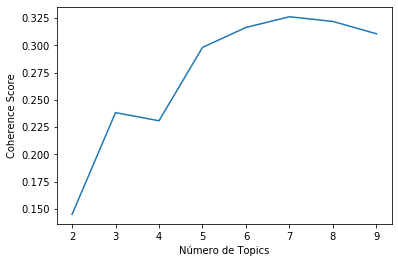

In [0]:
# Visualizamos el entrenamiento
plot_cohe_topics(coherence_values_o)

#####<pre>      Según la gráfica, el número de topics óptimo para el modelo de clustering de tweets de **OBAMA** son **7**.

In [0]:
# implementamos el modelo con 7 topics
lda_o = models.LdaModel(corpus_o, id2word = gensim_dict_o, num_topics = 7, iterations = 5, passes = 20, alpha = 'auto')

In [0]:
# Visualizamos con pyLDAvis
vis_o = pyLDAvis.gensim.prepare(lda_o, corpus_o, gensim_dict_o)
pyLDAvis.display(vis_o)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


#####<pre>      Mi nivel de inglés es paupérrimo y sé si podré identificar claramente el contenido de los topics...
#####<pre>      ...pero arriesgándome diría que probablemente OBAMA:
~~~
          > En el Topic 1 habla de temas como la inmigración y la economía de las familias de clase media americana
          > En el Topic 2 habla del progreso y de la fortaleza de la economía de América
          > En el Topic 3 trata temas de sanidad, salud, seguridad
          > En el Topic 4 hablá de combatir la polución y de acciones globales contra el cambio climático
          > En el Topic 5 parece que habla sobre alguna celebración o cumpleaños
          > El Topic 6 parece tratar temas de educación
          > El Topic 7 podría tratar sobre alguna aparición que hiciera en directo hablando sobre economía, energía y crecimiento
~~~

#####<pre>      Vamos ahora con los tweets de **TRUMP**

In [0]:
# generamos el vocabulario gensim
gensim_dict_t = Dictionary(docs_trump)

# generamos con gensim el corpus 
corpus_t = [gensim_dict_t.doc2bow(doc) for doc in docs_trump]

print(f"Del presidente Trump tenemos {len(corpus_t)} documentos con {len(gensim_dict_t)} tokens/palabras diferentes")

Del presidente Trump tenemos 2862 documentos con 5086 tokens/palabras diferentes


#####<pre>      Entrenamos el modelo ***LDA*** que implementaremos

In [0]:
# Entrenamos modelos con valores para número de topics del 2 al 10
model_list_t, coherence_values_t = compute_coherence_values(gensim_dict_t, corpus_t, docs_trump)

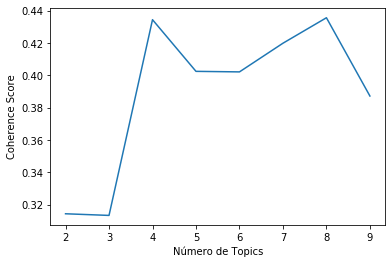

In [0]:
# Visualizamos el entrenamiento
plot_cohe_topics(coherence_values_t)

#####<pre>      Según la gráfica, el número de topics óptimo para el modelo de clustering de tweets de **TRUMP** son **8**.

In [0]:
# implementamos el modelo con 8 topics
lda_t = models.LdaModel(corpus_t, id2word = gensim_dict_t, num_topics = 8, iterations = 5, passes = 20, alpha = 'auto')

In [0]:
# Visualizamos con pyLDAvis
vis_t = pyLDAvis.gensim.prepare(lda_t, corpus_t, gensim_dict_t)
pyLDAvis.display(vis_t)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


#####<pre>      ...y arriesgándome de nuevo diría que probablemente TRUMP:
~~~
          > En el Topic 1 habla de leyes para la seguridad (veo la palabra 'wall' y recuerdo que quería erigir un muro para proteger la
            frontera con México)
          > En el Topic 2 parece hablar del gran coste del programa de salud 'ObamaCare'
          > En el Topic 3 habla de la polémica con los mercados orientales (China y Corea)
          > En el Topic 4 hablá de 'fake news' de la CNN sobre las elecciones
          > En el Topic 5 parece tratar de la campaña de desprestigio en las elecciones contra Hillary Clinton, de las investigaciones del
            posible espionaje ruso
          > En el Topic 6 habla de temas de impuestos varios y reformas
          > En el Topic 7 parece hablar de cosas que no le gustan: paises como Rusia, Siria, Puerto Rico, la organización terrorista Isis
          > En el Topic 8 parece hablar sobre alguna acción del gobierno en Florida, aunque también aparece 'Vietnam'
~~~

># **EJERCICIO 3**
###<pre>      ***Tweet Generation***



#####<pre>      Utilizaremos el mismo dataset del Ejercicio 2 y en este caso no lo vamos a preprocesar
~~~
          Queremos tener los tweets tal cual se escriben para intentar simularlos, por tanto no vamos a aplicar tratamientos de limpieza,
          lemmatización, ni tampoco filtrar stop-words 
~~~

In [43]:
# transponemos el dataset
df3 = df2.T

# eliminamos los tweets duplicados
df3 = df3.drop_duplicates()

# reindexamos el dataset para que no nos falten claves (por la eliminación de duplicaciones)
df3 = df3.reset_index()

# eliminamos la columna index antigua (que se queda residente tras reindexar)
df3.drop(['index'], axis = 1, inplace = True)

df3

,tweet,label
0,"“Low plastic stool, cheap but delicious noodle...",OBAMA
1,"This National Gun Violence Awareness Day, show...",OBAMA
2,We can never truly repay the debt we owe our f...,OBAMA
3,This Center is for the leaders of tomorrow who...,OBAMA
4,"Happy Mother’s Day to every mom out there, esp...",OBAMA
...,...,...
5718,...vast sums of money to NATO &amp; the United...,TRUMP
5719,Despite what you have heard from the FAKE NEWS...,TRUMP
5720,Great meeting with the @RepublicanStudy Commit...,TRUMP
5721,"""The President Changed. So Has Small Businesse...",TRUMP


#####<pre>      Por su marcado carisma, gran desparpajo, enorme soberbia y demostrada incapacidad para gobernar el mundo...
#####<pre>      ...elegimos simular los tweets del **Pato Donald**... mil perdones... quería decir de **Donald Trump**

In [44]:
# seleccionamos los tweets de Trump
df3 = df3.drop(df3[(df3['label'] != 'TRUMP')].index)

# eliminamos la columna label
df3.drop(['label'], axis = 1, inplace = True)

df3

,tweet
2861,My thoughts and prayers are with the families ...
2862,I am heading for Canada and the G-7 for talks ...
2863,Congratulations to the Washington Capitals on ...
2864,Looking forward to straightening out unfair Tr...
2865,Canada charges the U.S. a 270% tariff on Dair...
...,...
5718,...vast sums of money to NATO &amp; the United...
5719,Despite what you have heard from the FAKE NEWS...
5720,Great meeting with the @RepublicanStudy Commit...
5721,"""The President Changed. So Has Small Businesse..."


>># **Pipeline**

#####<pre>        Nos enfrentamos a un problema de Generación de Texto 'Language Modeling'

In [45]:
vocab = list()

for index, row in df3.iterrows():
  for word in row['tweet'].strip().split(' '):
    if word not in vocab:
      vocab.append(word)

print(f"Número de Palabras: {len(vocab)}")

Número de Palabras: 14647


#####<pre>      La columna -tweet- contiene 14.647 tokens diferentes

>># **Preprocesamiento**



#####<pre>      El preprocesamiento no será de limpieza, generaremos un dataset para entrenar la arquitectura del modelo

In [46]:
# generamos el corpus de documentos desde el que obtendremos el dataset de entrenamiento
corpus_trump = list()

for index, fila in df3.iterrows():
  tweet = fila['tweet']
  corpus_trump.append(tweet)

print(f"Del presidente Trump tenemos {len(corpus_trump)} tweets con {len(vocab)} palabras diferentes")

Del presidente Trump tenemos 2862 tweets con 14647 palabras diferentes


In [0]:
# tokenizamos los documentos del corpus por unigrams carácter ya que nuestro modelo irá prediciendo carácter a carácter
tokenizado = [list(x) for x in corpus_trump]

In [0]:
# generamos una lista con los 5 primeros caracteres de cada documento del corpus
# esta lista nos servirá para darle el pie de entrada para predecir al modelo
maxlen = 5

init_chars = [x[:maxlen] for x in tokenizado]

for i in range(len(init_chars)):
  aux = init_chars[i]
  aux.insert(0, '<SOS>')
  init_chars[i] = aux[:maxlen]

In [49]:
# generamos una lista con todos los unigrams del corpus
total_tokens = [t for s in corpus_trump for t in s]

print(f"El vocabulario total contiene {len(total_tokens)} unigrams/caracteres")

# agrupamos y contamos los unigrams
vocab_agrupado = Counter(total_tokens)

# generamos el vocabulario definitivo de unigrams quedándonos con aquellos que al menos estén 3 veces en el corpus
# añadimos al vocabulario los tokens de principio y final de documento y el token desconocido: <SOS>, <EOS> y <UNK>
vocab = [w for w, v in vocab_agrupado.items() if v > 2]
vocab = ['<UNK>', '<SOS>', '<EOS>'] + vocab

print(f"El vocabulario definitivo contiene {len(vocab)} unigrams/caracteres únicos")

El vocabulario total contiene 462564 unigrams/caracteres
El vocabulario definitivo contiene 109 unigrams/caracteres únicos


In [0]:
# indexamos el vocabulario y realizamos su inversa
c2id = {k: i for i, k in enumerate(vocab)}
id2c = {i: k for k, i in c2id.items()}

In [0]:
# generamos el dataset de entrenamiento como un array de duplas en las que el primer elemento es una lista secuencial de cinco unigrams y el segundo el unigram que haría el sexto en la secuencia
train = list()

for t in tokenizado:
  # a cada documento le insertamos los tokens <SOS> y <EOS>
  t.insert(0, '<SOS>')
  t.append('<EOS>')

  # Vamos extrayendo token a token, las duplas con la slice de 5 tokens y el sexto 
  for i in range(0, len(t) - maxlen):
    train.append((t[i:i + maxlen], t[i + maxlen]))

In [61]:
for i in range(0, 5):
  print(train[i])

(['<SOS>', 'M', 'y', ' ', 't'], 'h')
(['M', 'y', ' ', 't', 'h'], 'o')
(['y', ' ', 't', 'h', 'o'], 'u')
([' ', 't', 'h', 'o', 'u'], 'g')
(['t', 'h', 'o', 'u', 'g'], 'h')


>># **Implementación del Language Modeling con *LTSM***

In [0]:
# Las siguientes funciones son callbacks que nos van a servir para ir viendo el progreso del entrenamiento del modelo
# Están fielmente copiadas del visto durante las clases [RNNLM.ipynb]

SAMPLE_EVERY = 5      # Veremos un ejemplo de predicción cada 5 épocas

# helper function to sample an index from a probability array
def sample_pred(preds, temperature = 1.0):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)

  return np.argmax(probas)

class Sampletest(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % SAMPLE_EVERY == 0  and epoch > 0:
      data_test = []
      nb_samples = 1
      params = {'maxlen': maxlen, 'vocab': len(vocab), 'use_embeddings': True}

      for _ in range(nb_samples):
        data_test = choice(init_chars)
        for diversity in [0.2, 0.6, 1.2]:
          print('-------------- diversity:', diversity)
          sentence = copy(data_test)
          generated = copy(data_test)

          for i in range(len(data_test), 400):
            x_pred = np.zeros((1, params['maxlen']))

            for t, char in enumerate(sentence):
              x_pred[0, t] = c2id[char] if char in c2id else c2id['<UNK>']

            preds = self.model.predict(x_pred, verbose = 0)[0]
            next_index = sample_pred(preds, diversity)
            next_char = id2c[next_index]

            if next_char == '<EOS>':
              break

            generated += [next_char]
            sentence = sentence[1:] 
            sentence += [next_char]

          print(''.join(generated))

class HistoryDisplay(Callback):    
  def on_train_begin(self, logs = {}):
    self.losses = []
    self.accs = []
    self.epochs = []
    self.fig, self.ax = plt.subplots()
    plt.show()
    
    plt.ion()
    self.fig.show()
    self.fig.canvas.draw()
  
  def on_epoch_end(self, epoch, logs):
    self.epochs.append(epoch)
    self.losses.append(logs['loss'])
    self.accs.append(logs['acc'])

    if epoch % PLOT_EVERY == 0:        
      self.ax.clear()
      self.ax.plot(self.epochs, self.accs, 'g', label = 'acc')
      self.ax.plot(self.epochs, self.losses, 'b', label = 'loss')
      legend = self.ax.legend(loc = 'upper right', shadow=True, fontsize = 'x-large')
      display.clear_output(wait = True)
      display.display(pl.gcf())
      self.fig.canvas.draw()
      plt.draw()

class TimeHistory(Callback):
  def on_train_begin(self, logs = {}):
    self.times = []

  def on_epoch_begin(self, batch, logs = {}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, batch, logs = {}):
    self.times.append(time.time() - self.epoch_time_start)

In [0]:
# Montamos la arquitectura del modelo como una clase con sus metodos de compilación, entrenamiento y predicción
class LM:
  def __init__(self, **kwargs):
    self.params = kwargs.pop('params', None)

  # método de definición del modelo y compilación    
  def compile_model(self, params = {}):
    # capa de entrada de 5 features
    lm_input = Input(shape = (params['maxlen'],))

    # capa de embeddings
    embedding = Embedding(params['vocab'], params['emb_feats'])(lm_input)
    
    # capa LSTM bidireccional para facilitar el aprendizaje de las secuencias 
    lstm = CuDNNLSTM(params['rnn_hidden'], return_sequences = True)
    lmlstm = Bidirectional(lstm)(embedding)
    
    # segunda capa LSTM, unidireccional, para stackear
    stacklstm = CuDNNLSTM(params['rnn_hidden'], return_sequences=False, name='stack')
    stackedlstm = stacklstm(lmlstm)

    # capa densa de salida, con activación softmax 
    out = Dense(params['vocab'], activation='softmax')(stackedlstm)

    model = Model(lm_input, out)

    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    model.summary()

    return model

  # método para el entrenamiento del modelo
  def train(self, model, data, params={}):
    callbacks = self._get_callbacks()

    if 'shuffle' in params and params['shuffle']:
      shuffle(data)

    sentences, next_chars = zip(*data)
    x = np.zeros((len(data), params['maxlen']))
    y = np.zeros((len(data), params['vocab']))

    for i, sentence in enumerate(sentences):
      for t, char in enumerate(sentence):
        x[i, t] = c2id[char] if char in c2id else c2id['<UNK>']
          
      y[i, c2id[next_chars[i]] if next_chars[i] in c2id else c2id['<UNK>']] = 1

    model.fit(x, y, batch_size = params['batch_size'], epochs = params['epochs'], callbacks = callbacks, verbose = 1)

  # método para predicción del modelo
  def predict(self, model, data, params = {}):
    for diversity in [0.2, 0.6, 1.2]:
      print('-------------- diversity:', diversity)
      sentence = copy(data)
      generated = copy(data)

      for i in range(len(data), 240):
        x_pred = np.zeros((1, params['maxlen']))

        for t, char in enumerate(sentence):
          x_pred[0, t] = c2id[char] if char in c2id else c2id['<UNK>']
        
        preds = self.model.predict(x_pred, verbose = 0)[0]
        next_index = sample_pred(preds, diversity)
        next_char = id2c[next_index]

        if next_char == '<EOS>':
          break
        
        generated += [next_char]
        sentence = sentence[1:]
        sentence += [next_char]
      
      print(''.join(generated))
      
  def _get_callbacks(self, model_path = 'model_lm.h5'):
    es = EarlyStopping(monitor = 'loss', patience = 4, mode = 'auto', verbose = 0)
    save_best = ModelCheckpoint(model_path, monitor = 'loss', verbose = 0, save_best_only = True, save_weights_only = False, period = 2)
    rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 3, min_lr = 0.0001, verbose = 1)
    st = Sampletest()
    hd = HistoryDisplay()
    
    return [st, rlr, es]

#####<pre>      Parametrizaremos, definimos el modelo y lo compilamos

In [69]:
compile_params = {'maxlen': maxlen,         # features del conjunto de train
                  'vocab': len(vocab),      # longitud del vocabulario definitivo
                  'emb_feats': 100,         # número de features embeddings
                  'rnn_hidden': 256}        # densidad de neuronas de las capas LSTM

# instanciamos un modelo
lm = LM()

# invocamos su método de definición y compilación
lm_model = lm.compile_model(params = compile_params)



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 5, 100)            10900     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 5, 512)            733184    
_________________________________________________________________
stack (CuDNNLSTM)            (None, 256)               788480    
_________________________________________________________________
dense_2 (Dense)              (None, 109)               28013     
Total params: 1,560,577
Trainable params: 1,560,577
Non-trainable params: 0
_________________________________________________________________


#####<pre>      Parametrizaremos el entrenamiento del modelo y lo lanzamos
~~~
          Por el callback -EarlyStopping- de Keras, el entrenamiento podrá detenerse antes de llegar a las 500 épocas que parametrizaremos.
          Si en cuatro épocas consecutivas no disminuye la función de pérdidas el callback entenderá que el modelo no puede aprender más y
          finalizará el entrenamiento
~~~

In [73]:
train_params = {'epochs': 500,
                'batch_size': 512,
                'shuffle': True,
                'vocab': len(vocab),
                'maxlen': maxlen}

# invocamos el método de entrenamiento del modelo
lm.train(lm_model, data = train, params = train_params)

Epoch 1/500
453978/453978 [==============================] - 12s 25us/step - loss: 1.3617 - acc: 0.6177
Epoch 2/500
453978/453978 [==============================] - 11s 25us/step - loss: 1.3224 - acc: 0.6269
Epoch 3/500
453978/453978 [==============================] - 12s 26us/step - loss: 1.2886 - acc: 0.6344
Epoch 4/500
453978/453978 [==============================] - 12s 26us/step - loss: 1.2593 - acc: 0.6406
Epoch 5/500
453978/453978 [==============================] - 12s 26us/step - loss: 1.2320 - acc: 0.6464
Epoch 6/500
453978/453978 [==============================] - 12s 26us/step - loss: 1.2084 - acc: 0.6514
-------------- diversity: 0.2
<SOS>West Sive the people of the best to the people who would be a great honor to welcome to stated to stop the people who was a great honor to welcome to the people are work to the people are worker for the worker for the problem. We are was my great honor to welcome President of the people are worker dropped to the problem. We are worker drug

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


<SOS>The bigger for the many time highest stated the passed, we are and women who was a great honor to help!
-------------- diversity: 1.2
<SOS>The corrupt Mainst Drillion dollout today. #TaxCutsandJobsAlid in Wisconsidering, thenr, is horrifice I encourai_with birthday https://t.co/R
aL play so that is run get everyone is an hosta-an Juan, and take another their officer Heyer. Dems needed Tax I well. So spent the mostor whether) leaks of the Fake News Legal Schumer/Pelosile last terrible promises this is 5 out mysesperate. We can keeps,
Epoch 42/500
453978/453978 [==============================] - 12s 26us/step - loss: 0.8812 - acc: 0.7199
Epoch 43/500
453978/453978 [==============================] - 12s 27us/step - loss: 0.8790 - acc: 0.7208
Epoch 44/500
453978/453978 [==============================] - 12s 26us/step - loss: 0.8770 - acc: 0.7204
Epoch 45/500
453978/453978 [==============================] - 12s 27us/step - loss: 0.8747 - acc: 0.7208
Epoch 46/500
453978/453978 [========

#####<pre>      Como adelantamos, el entrenamiento se ha detenido tras la época 185 por no mejorar la función de pérdidas
#####<pre>      Haciendo un seguimiento del entrenamiento observamos que:
~~~
          > Con las diversity mas bajas (0.2 y 0.6) el modelo suelta generalmente frases muy largas, mientras que con la mayor diversity (1.2)
            las frases generadas suelen ser mas cortas y también más "locas"
          > En la época 133 hemos visto que el callback -ReduceLROnPlateau- ha entrado para disminuir el Learning Rate
          > Finalmente la accuracy del modelo entrenado está algo por encima de 0.74, lo cual no está nada mal para una arquitectura sencilla
            de Language Modeling 
~~~

>># **Modelo de Language Modeling con *LTSM* Prediciendo**

#####<pre>      Elegiremos aleatoriamente 5 principios de frase a ver que tal predice el modelo

In [99]:
test_params = {'maxlen': maxlen,
               'vocab': len(vocab),
               'use_embeddings': True}

for i in range(0, 5):
  test = choice(init_chars)

  pie = ""
  for i in test:
    pie += i

  print(f"\nPie de entrada: {pie}")

  for diversity in [0.2, 0.6, 1.2]:
    sentence = copy(test)
    generated = copy(test)

    for i in range(len(test), 240):
      x_pred = np.zeros((1, test_params['maxlen']))
      
      for t, char in enumerate(sentence):
        x_pred[0, t] = c2id[char] if char in c2id else c2id['<UNK>']

      preds = lm_model.predict(x_pred, verbose=0)[0]
      next_index = sample_pred(preds, diversity)
      next_char = id2c[next_index]

      if next_char == '<EOS>':
          break

      generated += [next_char]
      sentence = sentence[1:] 
      sentence += [next_char]

    salida = ''.join(generated)
    salida = f"\t----- diversity: {diversity}\n\t\t\t\t" + salida[5:]
    print(salida)


Pie de entrada: <SOS>All 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


	----- diversity: 0.2
				All of the people of the U.S. is being made a free zones, in the FBI and the U.S. is being made up a lot of the people of the United States that the Democrats are with the Fake News Media will be a total disaster Abe of the U.S. history an
	----- diversity: 0.6
				All of Iran Deals with the phony Russia, Russia Witch Hunt!
	----- diversity: 1.2
				All among time intel and with, are fight choice and, and family. #TaxCutsandJobsAct https://t.co/k92n https://t.co/cyRAQAKhy2 https://t.co/pl’5(htke Rasmussen very eDcitreasure Vettingent is highly redrawn election concerning our grieved. 

Pie de entrada: <SOS>Wond
	----- diversity: 0.2
				Wonderful to our country is a total disrespect for the U.S. history of the FBI and the same time to the United States the working at the U.S. Coast Guard to the U.S. history of the Fake News Media is a great honor to welcome to the Fake Ne
	----- diversity: 0.6
				Wonderstandard care all about the Fake Dossier, he hard for our

---


>#     **COMENTARIOS Y AGRADECIMIENTOS**
                        Como nota final de este trabajo me gustaría dar las gracias al profesor David Torrejón, por su
                    atención (tanto en las clases como en Slack) y por su generosidad preparando toda la documentación
                                                                                 teórica y práctica para la asignatura.
                      El NLP es un mundo denso, muy complejo y creo que el profesor ha hecho un gran trabajo y un gran
                         esfuerzo para que los alumnos pudieramos llegar a entender lo imprescindible y más importante.
                  Personalmente me ha costado llegar hasta aquí... algunos conceptos son realmente complicados y nunca
                    había experimentado antes con el tratamiento del "texto libre"... espero haber conseguido elaborar
                      un trabajo digno y medianamente decente, aunque el mayor mérito vuelve a ser del profesor ya que,
                                  en los colaboratory de la asignatura, están estos ejercicios prácticamente resueltos.
                                           Sin más, mi más sincero agradecimiento por todas las cosas que he aprendido.
                                                                                                 F. Javier Gonzálvez